In [1]:
# Cell 2 — Imports & configuration
import os
import math
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from transformers import AutoModel, AutoImageProcessor
import timm

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- CONFIG ----------------
class Config:
    # Colab-friendly default paths (change if needed)
    BASE_DIR = "melspectrograms_dataset"   # your dataset: train/ validation/ test/ folders
    GFT_MODEL_PATH = "gft/best_full_gft_gala_pps.pth" # path to your saved GFT model (upload to Colab)
    IMG_SIZE = 224
    BATCH_SIZE = 16     # reduce if OOM
    NUM_WORKERS = 0
    COATNET_MODEL = "coatnet_0_rw_224"
    PRETRAINED_COATNET = True
    SAVE_DIR = "checkpoints_fusion_v2"
    os.makedirs(SAVE_DIR, exist_ok=True)

    # training phases
    HEAD_EPOCHS = 6
    PARTIAL_EPOCHS = 18
    FULL_EPOCHS = 12

    HEAD_LR = 3e-4
    PARTIAL_LR = 5e-5
    FULL_LR = 5e-6

    WEIGHT_DECAY = 0.05
    LR_WARMUP_EPOCHS = 3
    PATIENCE = 8

    MIXUP_ALPHA = 0.3
    SPEC_AUG_FREQ = 20
    SPEC_AUG_TIME = 30
    DROP_RATE = 0.4

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()
print("Device:", config.DEVICE)
print("Dataset base dir:", config.BASE_DIR)
print("GFT checkpoint (expected):", config.GFT_MODEL_PATH)


Device: cuda
Dataset base dir: melspectrograms_dataset
GFT checkpoint (expected): gft/best_full_gft_gala_pps.pth


In [2]:
# Cell 3 — Model definitions: minimal GFT parts, cross-attention fusion, and fusion model

# Minimal GFT components (sufficient to load your checkpoint with strict=False)
class GALA_Attention(nn.Module):
    def __init__(self, dim, n_heads=6, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.focal_gamma = nn.Parameter(torch.ones(n_heads, 1, 1))
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn_w = torch.softmax(attn, dim=-1)
        focal = torch.pow(1.0 - attn_w, self.focal_gamma)
        attn_mod = attn_w * focal
        attn_mod = attn_mod / (attn_mod.sum(dim=-1, keepdim=True) + 1e-6)
        out = (self.attn_drop(attn_mod) @ v).transpose(1,2).reshape(B,N,C)
        return self.proj_drop(self.proj(out))

class GFT_Encoder_Minimal(nn.Module):
    def __init__(self, embed_dim, num_stages=3, n_heads=6, drop_rate=0.3):
        super().__init__()
        self.stages = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(embed_dim),
                GALA_Attention(embed_dim, n_heads=n_heads, attn_drop=drop_rate*0.5, proj_drop=drop_rate*0.5),
                nn.LayerNorm(embed_dim),
                nn.Linear(embed_dim, embed_dim),
                nn.GELU(),
                nn.Dropout(drop_rate)
            ) for _ in range(num_stages)
        ])
    def forward(self, x):
        out = x
        for s in self.stages:
            out = s(out)
        return out

# Minimal DinoV2+GFT wrapper to load checkpoint
class DinoV2_GFT_Minimal(nn.Module):
    def __init__(self, model_name="facebook/dinov2-small", num_classes=10, gft_stages=3, n_heads=6, drop_rate=0.3):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        embed_dim = self.backbone.config.hidden_size
        self.embed_dim = embed_dim
        self.gft_encoder = GFT_Encoder_Minimal(embed_dim, num_stages=gft_stages, n_heads=n_heads, drop_rate=drop_rate)
        self.pool_norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 512), nn.GELU(), nn.Dropout(drop_rate),
            nn.Linear(512, 256), nn.GELU(), nn.Dropout(drop_rate*0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, pixel_values, token_mask=None):
        outputs = self.backbone(pixel_values=pixel_values)
        tokens = outputs.last_hidden_state
        if token_mask is not None:
            tokens = tokens * token_mask.unsqueeze(-1)
        features = self.gft_encoder(tokens)
        pooled = torch.mean(features, dim=1)
        pooled = self.pool_norm(pooled)
        logits = self.classifier(pooled)
        return logits

# Cross-Attention Fusion block
class CrossAttentionFusion(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.dim = dim
        self.q = nn.Linear(dim, dim)
        self.k = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, dim)
        self.proj_out = nn.Linear(dim, dim)
        self.scale = (dim//heads) ** -0.5
    def forward(self, a, b):
        # a, b : (B, D)
        B = a.shape[0]
        D = a.shape[1]
        # project
        q = self.q(a).view(B, self.heads, -1)     # (B, heads, D/heads)
        k = self.k(b).view(B, self.heads, -1)
        v = self.v(b).view(B, self.heads, -1)
        # scaled dot product per-head (we use simplified matmul across head dim)
        # compute attention scores along last dim (since we collapsed sequence dim into features)
        attn = (q * self.scale) * k              # elementwise sim -> (B, heads, D/heads)
        attn = torch.softmax(attn, dim=-1)
        fused = (attn * v).view(B, -1)           # (B, D)
        return self.proj_out(fused)

# Fusion model: loads GFT checkpoint, creates CoAtNet branch, projects and fuses
class GFT_CoAtNet_Fusion_v2(nn.Module):
    def __init__(self, gft_checkpoint_path, num_classes, coatnet_name="coatnet_0_rw_224",
                 coatnet_pretrained=True, gft_model_name="facebook/dinov2-small", gft_stages=3, gft_heads=6, proj_dim=768, drop_rate=0.4):
        super().__init__()
        # gft branch
        self.gft_branch = DinoV2_GFT_Minimal(gft_model_name, num_classes, gft_stages=gft_stages, n_heads=gft_heads, drop_rate=drop_rate)
        # load GFT checkpoint if available
        if gft_checkpoint_path and os.path.exists(gft_checkpoint_path):
            print("Loading GFT checkpoint (strict=False)...")
            state = torch.load(gft_checkpoint_path, map_location="cpu")
            try:
                self.gft_branch.load_state_dict(state, strict=False)
                print("GFT weights loaded (strict=False).")
            except Exception as e:
                # try common keys
                if isinstance(state, dict):
                    for key in ("state_dict","model_state_dict","model"):
                        if key in state and isinstance(state[key], dict):
                            self.gft_branch.load_state_dict(state[key], strict=False)
                            print(f"Loaded checkpoint['{key}'] into gft_branch (strict=False).")
                            break
                        # fallback to partial load
                    else:
                        # attempt partial direct dict load
                        try:
                            self.gft_branch.load_state_dict(state, strict=False)
                            print("Loaded checkpoint attempt (strict=False).")
                        except Exception as ee:
                            print("Warning: unable to auto-load checkpoint fully. Proceeding with HF backbone weights.")
                else:
                    print("Warning: checkpoint format unrecognized.")
        else:
            print("GFT checkpoint not found; using HF backbone weights.")

        # coatnet branch
        print(f"Creating CoAtNet: {coatnet_name} (pretrained={coatnet_pretrained})")
        self.coatnet = timm.create_model(coatnet_name, pretrained=coatnet_pretrained, num_classes=0, global_pool="avg")
        coat_dim = self.coatnet.num_features

        # projection heads and fusion blocks
        gft_dim = self.gft_branch.embed_dim
        self.gft_proj = nn.Sequential(nn.Linear(gft_dim, proj_dim), nn.GELU(), nn.LayerNorm(proj_dim))
        self.coat_proj = nn.Sequential(nn.Linear(coat_dim, proj_dim), nn.GELU(), nn.LayerNorm(proj_dim))

        self.cross = CrossAttentionFusion(proj_dim, heads=8)
        fusion_in = proj_dim * 3  # gft_proj, coat_proj, cross
        self.fusion_head = nn.Sequential(
            nn.Linear(fusion_in, 1024), nn.GELU(), nn.Dropout(drop_rate),
            nn.Linear(1024, 512), nn.GELU(), nn.Dropout(drop_rate*0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, token_mask=None):
        # GFT features
        outputs = self.gft_branch.backbone(pixel_values=x)
        tokens = outputs.last_hidden_state
        if token_mask is not None:
            tokens = tokens * token_mask.unsqueeze(-1)
        gft_feats = self.gft_branch.gft_encoder(tokens)
        gft_pooled = torch.mean(gft_feats, dim=1)   # (B, gft_dim)
        gft_proj = self.gft_proj(gft_pooled)        # (B, proj_dim)

        # CoAtNet features
        coat_feats = self.coatnet(x)                # (B, coat_dim)
        coat_proj = self.coat_proj(coat_feats)      # (B, proj_dim)

        # cross-attention fusion
        cross = self.cross(gft_proj, coat_proj)     # (B, proj_dim)

        fused = torch.cat([gft_proj, coat_proj, cross], dim=1)
        # layer-norm on fused vector for stability
        fused = nn.functional.layer_norm(fused, fused.shape[1:])
        logits = self.fusion_head(fused)
        return logits


In [3]:
# Cell 4 — dataset, transforms, dataloaders
class MelSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split="train", transform=None):
        self.transform = transform
        self.data_dir = os.path.join(base_dir, split)
        if not os.path.isdir(self.data_dir):
            raise FileNotFoundError(f"Directory not found: {self.data_dir}")
        self.classes = sorted([d for d in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        self.paths, self.labels = [], []
        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            for f in os.listdir(cls_dir):
                if f.lower().endswith((".png",".jpg",".jpeg")):
                    self.paths.append(os.path.join(cls_dir, f))
                    self.labels.append(self.class_to_idx[cls])
        print(f"Found {len(self.paths)} images in {split} with {len(self.classes)} classes.")

    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform: img = self.transform(img)
        return img, label

# transforms using DINOv2 processor normalization
proc = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
mean, std = proc.image_mean, proc.image_std

train_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
val_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = MelSpectrogramDataset(config.BASE_DIR, "train", train_transform)
val_dataset = MelSpectrogramDataset(config.BASE_DIR, "validation", val_transform)
test_dataset = MelSpectrogramDataset(config.BASE_DIR, "test", val_transform)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS)

num_classes = len(train_dataset.classes)
print("Num classes:", num_classes)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Found 4021 images in train with 6 classes.
Found 73 images in validation with 6 classes.
Found 74 images in test with 6 classes.
Num classes: 6


In [4]:
# Cell 5 — augment, mixup, loss helpers
class SpecAugment(nn.Module):
    def __init__(self, freq_mask_param=20, time_mask_param=30):
        super().__init__()
        self.F = freq_mask_param
        self.T = time_mask_param
    def forward(self, x):
        B,C,H,W = x.shape
        # freq masks (height)
        f = np.random.randint(0, min(self.F, H)+1)
        if f>0:
            f0 = np.random.randint(0, max(1, H - f))
            x[:, :, f0:f0+f, :] = 0
        # time masks (width)
        t = np.random.randint(0, min(self.T, W)+1)
        if t>0:
            t0 = np.random.randint(0, max(1, W - t))
            x[:, :, :, t0:t0+t] = 0
        return x

spec_augment = SpecAugment(freq_mask_param=config.SPEC_AUG_FREQ, time_mask_param=config.SPEC_AUG_TIME)

def mixup_data(x, y, alpha=0.3, device="cuda"):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# loss
class GradientFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, targets):
        ce = nn.functional.cross_entropy(logits, targets, reduction="none")
        p = torch.exp(-ce)
        probs = torch.softmax(logits, dim=1)
        target_probs = probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        grad_weight = torch.abs(target_probs - 1.0)
        focal = self.alpha * (1 - p) ** self.gamma * (1 + grad_weight)
        loss = focal * ce
        return loss.mean() if self.reduction=="mean" else loss.sum()


In [5]:
# Cell 6 — train and validation functions (AMP)
scaler = torch.cuda.amp.GradScaler()

def train_epoch(model, dataloader, criterion, optimizer, device, mixup_alpha=0.0, spec_aug=True):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    pbar = tqdm(dataloader, desc="Train")
    for imgs, labels in pbar:
        imgs = imgs.to(device); labels = labels.to(device)
        if spec_aug:
            imgs = spec_augment(imgs)
        if mixup_alpha > 0:
            inputs, targets_a, targets_b, lam = mixup_data(imgs, labels, mixup_alpha, device)
        else:
            inputs, targets_a, targets_b, lam = imgs, labels, labels, 1.0

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            logits = model(inputs)
            loss = mixup_criterion(criterion, logits, targets_a, targets_b, lam)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = running_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Val")
        for imgs, labels in pbar:
            imgs = imgs.to(device); labels = labels.to(device)
            with torch.cuda.amp.autocast():
                logits = model(imgs)
                loss = criterion(logits, labels)
            running_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc


In [6]:
# Cell 7 — Phase 1: Train Fusion Head
# Creates model, freezes large parts, trains only projection heads + fusion head.

model = GFT_CoAtNet_Fusion_v2(
    gft_checkpoint_path=config.GFT_MODEL_PATH,
    num_classes=num_classes,
    coatnet_name=config.COATNET_MODEL,
    coatnet_pretrained=config.PRETRAINED_COATNET
).to(config.DEVICE)
print("Model created.")

# Freeze both branches initially
for p in model.gft_branch.parameters(): p.requires_grad = False
for p in model.coatnet.parameters(): p.requires_grad = False

# Enable projections + fusion head
for p in model.gft_proj.parameters(): p.requires_grad = True
for p in model.coat_proj.parameters(): p.requires_grad = True
for p in model.cross.parameters(): p.requires_grad = True
for p in model.fusion_head.parameters(): p.requires_grad = True

# Prepare optimizer and criterion
criterion = GradientFocalLoss(alpha=0.25, gamma=2.0)
opt_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.AdamW(opt_params, lr=config.HEAD_LR, weight_decay=config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, config.HEAD_EPOCHS - config.LR_WARMUP_EPOCHS))

best_val = 0.0
for epoch in range(config.HEAD_EPOCHS):
    print(f"\nHEAD PHASE Epoch {epoch+1}/{config.HEAD_EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE, mixup_alpha=0.0, spec_aug=True)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, config.DEVICE)
    scheduler.step()
    print(f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")
    if val_acc > best_val:
        best_val = val_acc
        save_path = os.path.join(config.SAVE_DIR, "best_head_fusion_v2.pth")
        torch.save(model.state_dict(), save_path)
        print("Saved best head:", save_path)

print("Head training done. Best val:", best_val)


Loading GFT checkpoint (strict=False)...
GFT weights loaded (strict=False).
Creating CoAtNet: coatnet_0_rw_224 (pretrained=True)
Model created.

HEAD PHASE Epoch 1/6


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.0781 Acc 0.8754 | Val Loss 0.1434 Acc 0.7671
Saved best head: checkpoints_fusion_v2\best_head_fusion_v2.pth

HEAD PHASE Epoch 2/6


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.0626 Acc 0.8834 | Val Loss 0.1402 Acc 0.8493
Saved best head: checkpoints_fusion_v2\best_head_fusion_v2.pth

HEAD PHASE Epoch 3/6


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.0565 Acc 0.8946 | Val Loss 0.1144 Acc 0.8219

HEAD PHASE Epoch 4/6


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.0535 Acc 0.9003 | Val Loss 0.1142 Acc 0.8219

HEAD PHASE Epoch 5/6


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.0526 Acc 0.8988 | Val Loss 0.1104 Acc 0.8219

HEAD PHASE Epoch 6/6


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.0630 Acc 0.8796 | Val Loss 0.1428 Acc 0.8082
Head training done. Best val: 0.8493150684931506


In [7]:
# Cell 8 — Phase 2: Partial fine-tune
# Load best head and unfreeze selective parts of coatnet and last GFT stage

# load best head checkpoint if available
head_ckpt = os.path.join(config.SAVE_DIR, "best_head_fusion_v2.pth")
if os.path.exists(head_ckpt):
    model.load_state_dict(torch.load(head_ckpt, map_location=config.DEVICE), strict=False)
    print("Loaded head checkpoint.")
else:
    print("Head checkpoint not found; continuing with current model state.")

# Unfreeze coatnet (option: selectively unfreeze last blocks)
for name, p in model.coatnet.named_parameters():
    # heuristics: if you know block names you can target them; here we unfreeze all coatnet params
    p.requires_grad = True

# Unfreeze last GFT stage parameters (approx: stages[-1])
for name, p in model.gft_branch.named_parameters():
    # enable last stage (stages.N-1)
    if "stages.2" in name or "stages.{}".format(len(model.gft_branch.gft_encoder.stages)-1) in name:
        p.requires_grad = True
    else:
        # keep earlier gft stages frozen
        if "gft_encoder" in name:
            p.requires_grad = False

# ensure projection & fusion remain trainable
for p in model.gft_proj.parameters(): p.requires_grad = True
for p in model.coat_proj.parameters(): p.requires_grad = True
for p in model.cross.parameters(): p.requires_grad = True
for p in model.fusion_head.parameters(): p.requires_grad = True

# Prepare optimizer with LR groups
param_groups = [
    {"params": model.fusion_head.parameters(), "lr": config.PARTIAL_LR},
    {"params": model.gft_proj.parameters(), "lr": config.PARTIAL_LR},
    {"params": model.coat_proj.parameters(), "lr": config.PARTIAL_LR},
    {"params": [p for n,p in model.gft_branch.named_parameters() if p.requires_grad], "lr": config.PARTIAL_LR * 0.5},
    {"params": model.coatnet.parameters(), "lr": config.PARTIAL_LR * 0.5}
]
optimizer = optim.AdamW(param_groups, weight_decay=config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, config.PARTIAL_EPOCHS - config.LR_WARMUP_EPOCHS))

best_val = 0.0
epochs_no_improve = 0
for epoch in range(config.PARTIAL_EPOCHS):
    print(f"\nPARTIAL PHASE Epoch {epoch+1}/{config.PARTIAL_EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE, mixup_alpha=config.MIXUP_ALPHA, spec_aug=True)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, config.DEVICE)
    scheduler.step()
    print(f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")
    if val_acc > best_val:
        best_val = val_acc
        epochs_no_improve = 0
        save_path = os.path.join(config.SAVE_DIR, "best_partial_fusion_v2.pth")
        torch.save(model.state_dict(), save_path)
        print("Saved best partial:", save_path)
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= config.PATIENCE:
        print("Early stopping (partial) triggered.")
        break

print("Partial training done. Best val:", best_val)


Loaded head checkpoint.

PARTIAL PHASE Epoch 1/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1913 Acc 0.5633 | Val Loss 0.1216 Acc 0.7945
Saved best partial: checkpoints_fusion_v2\best_partial_fusion_v2.pth

PARTIAL PHASE Epoch 2/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1685 Acc 0.5315 | Val Loss 0.1151 Acc 0.8219
Saved best partial: checkpoints_fusion_v2\best_partial_fusion_v2.pth

PARTIAL PHASE Epoch 3/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1691 Acc 0.5715 | Val Loss 0.1138 Acc 0.8082

PARTIAL PHASE Epoch 4/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1648 Acc 0.5106 | Val Loss 0.1119 Acc 0.8082

PARTIAL PHASE Epoch 5/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1617 Acc 0.5429 | Val Loss 0.1083 Acc 0.8356
Saved best partial: checkpoints_fusion_v2\best_partial_fusion_v2.pth

PARTIAL PHASE Epoch 6/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1601 Acc 0.5531 | Val Loss 0.1123 Acc 0.8219

PARTIAL PHASE Epoch 7/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1650 Acc 0.5526 | Val Loss 0.1048 Acc 0.8082

PARTIAL PHASE Epoch 8/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1659 Acc 0.5603 | Val Loss 0.1074 Acc 0.8356

PARTIAL PHASE Epoch 9/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1566 Acc 0.5374 | Val Loss 0.1123 Acc 0.8356

PARTIAL PHASE Epoch 10/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1608 Acc 0.5265 | Val Loss 0.1167 Acc 0.8630
Saved best partial: checkpoints_fusion_v2\best_partial_fusion_v2.pth

PARTIAL PHASE Epoch 11/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1599 Acc 0.5292 | Val Loss 0.1060 Acc 0.8356

PARTIAL PHASE Epoch 12/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1517 Acc 0.5655 | Val Loss 0.1132 Acc 0.8356

PARTIAL PHASE Epoch 13/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1515 Acc 0.5581 | Val Loss 0.1126 Acc 0.8493

PARTIAL PHASE Epoch 14/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1564 Acc 0.5680 | Val Loss 0.1128 Acc 0.8356

PARTIAL PHASE Epoch 15/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1454 Acc 0.5735 | Val Loss 0.1099 Acc 0.8356

PARTIAL PHASE Epoch 16/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1478 Acc 0.5663 | Val Loss 0.1120 Acc 0.8493

PARTIAL PHASE Epoch 17/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1538 Acc 0.5359 | Val Loss 0.1111 Acc 0.8493

PARTIAL PHASE Epoch 18/18


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1607 Acc 0.5608 | Val Loss 0.1125 Acc 0.8356
Early stopping (partial) triggered.
Partial training done. Best val: 0.863013698630137


In [8]:
# Cell 9 — Phase 3: Full fine-tune (unfreeze everything and train)
# Load best partial if exists
partial_ckpt = os.path.join(config.SAVE_DIR, "best_partial_fusion_v2.pth")
if os.path.exists(partial_ckpt):
    model.load_state_dict(torch.load(partial_ckpt, map_location=config.DEVICE), strict=False)
    print("Loaded partial checkpoint.")
else:
    print("Partial checkpoint not found; continuing from current model.")

# Unfreeze all params
for p in model.parameters(): p.requires_grad = True

# optimizer and scheduler (lower LR)
optimizer = optim.AdamW(model.parameters(), lr=config.FULL_LR, weight_decay=config.WEIGHT_DECAY*0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, config.FULL_EPOCHS - config.LR_WARMUP_EPOCHS))

best_val = 0.0
epochs_no_improve = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
for epoch in range(config.FULL_EPOCHS):
    print(f"\nFULL PHASE Epoch {epoch+1}/{config.FULL_EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE, mixup_alpha=config.MIXUP_ALPHA, spec_aug=True)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, config.DEVICE)
    scheduler.step()
    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
    print(f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")
    if val_acc > best_val:
        best_val = val_acc
        epochs_no_improve = 0
        save_path = os.path.join(config.SAVE_DIR, "best_full_fusion_v2.pth")
        torch.save(model.state_dict(), save_path)
        print("Saved best full:", save_path)
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= config.PATIENCE:
        print("Early stopping (full) triggered.")
        break

print("Full training done. Best val:", best_val)
# optional: save training history
hist_path = os.path.join(config.SAVE_DIR, "history_fusion_v2.npy")
np.save(hist_path, history)
print("Saved history:", hist_path)


Loaded partial checkpoint.

FULL PHASE Epoch 1/12


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1590 Acc 0.5613 | Val Loss 0.1229 Acc 0.8493
Saved best full: checkpoints_fusion_v2\best_full_fusion_v2.pth

FULL PHASE Epoch 2/12


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1470 Acc 0.5454 | Val Loss 0.1473 Acc 0.8082

FULL PHASE Epoch 3/12


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1510 Acc 0.5655 | Val Loss 0.1337 Acc 0.8493

FULL PHASE Epoch 4/12


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1436 Acc 0.5553 | Val Loss 0.1442 Acc 0.8356

FULL PHASE Epoch 5/12


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1370 Acc 0.5277 | Val Loss 0.1496 Acc 0.8493

FULL PHASE Epoch 6/12


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1474 Acc 0.5979 | Val Loss 0.1400 Acc 0.8356

FULL PHASE Epoch 7/12


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1423 Acc 0.5362 | Val Loss 0.1229 Acc 0.8356

FULL PHASE Epoch 8/12


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1301 Acc 0.5904 | Val Loss 0.1326 Acc 0.8082

FULL PHASE Epoch 9/12


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1340 Acc 0.5533 | Val Loss 0.1293 Acc 0.8082
Early stopping (full) triggered.
Full training done. Best val: 0.8493150684931506
Saved history: checkpoints_fusion_v2\history_fusion_v2.npy


Evaluating checkpoint: checkpoints_fusion_v2\best_full_fusion_v2.pth
Loading GFT checkpoint (strict=False)...
GFT weights loaded (strict=False).
Creating CoAtNet: coatnet_0_rw_224 (pretrained=True)


Testing:   0%|          | 0/5 [00:00<?, ?it/s]


Test Accuracy: 0.8514 (85.14%)

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6154    0.6154    0.6154        13
           Laryngozele     0.8000    0.8889    0.8421         9
           Vox senilis     0.8462    0.8462    0.8462        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8333    0.7692    0.8000        13

              accuracy                         0.8514        74
             macro avg     0.8491    0.8533    0.8506        74
          weighted avg     0.8518    0.8514    0.8511        74



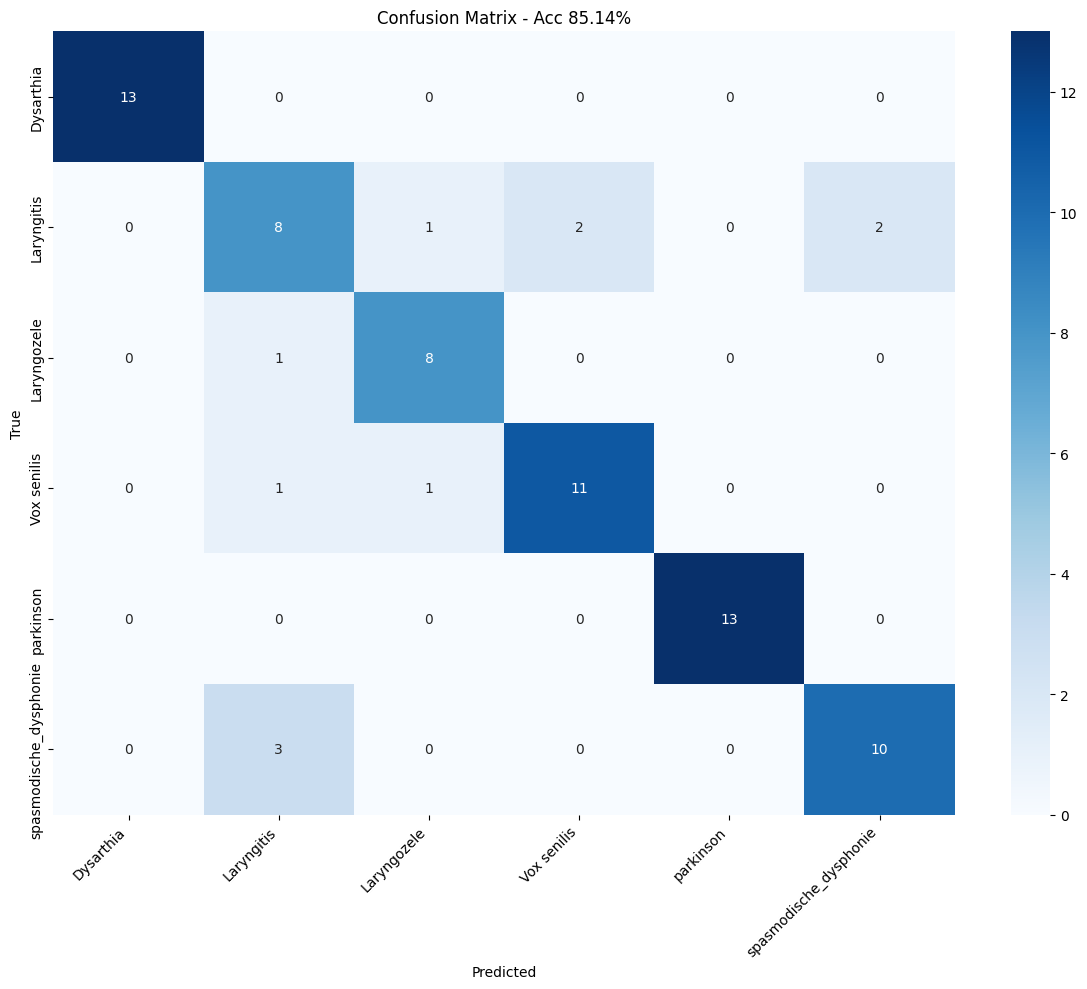

In [9]:
# Cell 10 — Testing + classification report + confusion matrix
ckpt_candidate = os.path.join(config.SAVE_DIR, "best_full_fusion_v2.pth")
if not os.path.exists(ckpt_candidate):
    # fallback options
    for f in ["best_partial_fusion_v2.pth", "best_head_fusion_v2.pth"]:
        p = os.path.join(config.SAVE_DIR, f)
        if os.path.exists(p):
            ckpt_candidate = p
            break

print("Evaluating checkpoint:", ckpt_candidate)

# instantiate model skeleton and load weights
eval_model = GFT_CoAtNet_Fusion_v2(
    gft_checkpoint_path=config.GFT_MODEL_PATH,
    num_classes=num_classes,
    coatnet_name=config.COATNET_MODEL,
    coatnet_pretrained=config.PRETRAINED_COATNET
).to(config.DEVICE)

eval_state = torch.load(ckpt_candidate, map_location=config.DEVICE)
eval_model.load_state_dict(eval_state, strict=False)
eval_model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    pbar = tqdm(test_loader, desc="Testing")
    for imgs, labels in pbar:
        imgs = imgs.to(config.DEVICE)
        labels = labels.to(config.DEVICE)
        logits = eval_model(imgs)
        _, preds = torch.max(logits, dim=1)
        all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix - Acc {acc*100:.2f}%")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
